<a href="https://colab.research.google.com/github/zpaluszewska/ZUM_NLP_2/blob/main/ZUM2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install tweepy
import tweepy
import pandas as pd
import numpy as np

import re

import gensim
from gensim.utils import simple_preprocess

from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.tokenize import RegexpTokenizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

from seaborn import heatmap
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Klucze do API twittera
%run ./drive/MyDrive/ZUM/my_keys.ipynb

In [ ]:
#Połączenie z Twitter API
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

try:
    api.verify_credentials()
    print("Success")
except:
    print("Error")

Success


In [ ]:
tweet_id_pl = pd.read_csv("/content/drive/MyDrive/ZUM/pl_covid_tweets_clean.txt", sep="\t", header=None)
tweet_id_pl[:5]

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,0,1,2,3,4
0,tweet_id,date,time,lang,country_place
1,1219370546116407297,2020-01-20,21:26:07,pl,NaN
2,1220355028961103872,2020-01-23,14:38:06,pl,NaN
3,1221099475982323712,2020-01-25,15:56:16,pl,NaN
4,1221232003393167360,2020-01-26,00:42:53,pl,NaN


In [ ]:
tweet_id_pl.columns = ['tweet_id', 'date', 'time','lang','country_place']

In [ ]:
print(tweet_id_pl['tweet_id'][1:])
print("\n\n Pierwszy id_tweet: " + tweet_id_pl['tweet_id'][1:][1])

1         1219370546116407297
2         1220355028961103872
3         1221099475982323712
4         1221232003393167360
5         1221344960194195457
                 ...         
583801    1414043803485409285
583802    1414043861954015232
583803    1414049377589645315
583804    1414064422453137411
583805    1414064490786734081
Name: tweet_id, Length: 583805, dtype: object


 Pierwszy id_tweet: 1219370546116407297


In [ ]:
#Sprawdzam, czy wszystkie tweety z pliku są w języku polskim
for lang in tweet_id_pl['lang'][1:]:
  if lang != "pl":
    print(lang)

In [ ]:
import pickle as pkl
!pip3 install pickle5

In [ ]:
i = 0
l = []

while i < len(source_list):
    try:
        query = api.lookup_statuses(list(source['tweet_id'][i:i+100]), tweet_mode='extended')
        for twit in query:
            l.append([twit.id, twit.full_text])
        print(i, end=' ')
        i += 100
    except tweepy.BadRequest:
        print('end.')
        break
    except tweepy.TweepyException:
        print('retry', end=' ')
        time.sleep(60)
            
    df = pd.DataFrame(l)
    
df.to_pickle('tweety.pkl')

0 100 200 end.


In [ ]:
#Odczytanie tweetów
import pickle5 as pickle
with open("/content/drive/MyDrive/ZUM/tweety.pkl", "rb") as f:
  tweets = pickle.load(f)

tweets= pd.DataFrame(tweets)
tweets.to_csv(r"/content/drive/MyDrive/ZUM/tweets_csv.csv")


In [ ]:
tweets

,0,1,2,3
0,1221491639190945795,2020-01-26 17:54:35+00:00,maciej_pater,"Kiedy #coronavirus dotrze do Polski, napotka o..."
1,1221831858138370049,2020-01-27 16:26:30+00:00,Joanna_D_a_r_c,Kolejni Polacy chcą wrócić z Wuhan https://t.c...
2,1221845753313755139,2020-01-27 17:21:43+00:00,Dumna_z_Polski,A tymczasem w Wuhan odcięto od reszty świata o...
3,1221837704981307392,2020-01-27 16:49:44+00:00,ivazet,@PatrykWachowiec @KancelariaSejmu nie zdziwię ...
4,1221841877927899141,2020-01-27 17:06:19+00:00,wPolityce_pl,".@MSZ_RP: 19 Polaków chce wrócić z Wuhan, w am..."
...,...,...,...,...
598842,1469798775329800203,2021-12-11 22:38:30+00:00,rocnat,Na 100 osób co najmniej 99 nie jest Włodzimier...
598843,1469830863613579267,2021-12-12 00:46:00+00:00,_LunarBird_,Gdyby mój brat nie był imbecylem i się zaszcze...
598844,1469877682745876489,2021-12-12 03:52:03+00:00,KrzysztofGrzeg7,@Margherita_PPP @uszinek Często bywa odwrotnie...
598845,1469786677182750721,2021-12-11 21:50:25+00:00,Jan37828283,@Niktnejm @Fishing_Fever69 dlaczego skutki szc...


In [ ]:
tweets.columns = ["id_tweets","date","name","text"]

In [ ]:
tweets = tweets.drop(columns=["id_tweets","date","name"])

In [ ]:
#Sprawdzenie czy występują nulle
np.sum(tweets.isnull().any(axis=1))
print('Liczba nulli: ', tweets.isnull().sum())


Liczba nulli:  text    0
dtype: int64


In [ ]:
#Sprawdzenie czy występują duplikaty => jeżeli tak usunięcie ich
print('Liczba duplikatów:',tweets.duplicated().sum())
print(tweets[tweets.duplicated(keep=False)].tail())

tweets = tweets.drop_duplicates()

Liczba duplikatów: 3042
                                                     text
598675  @MZ_GOV_PL Japonia oficjalnie informuje o #Myo...
598697  @MZ_GOV_PL Japonia oficjalnie informuje o #Myo...
598704  @JkmMikke Japonia oficjalnie informuje o #Myoc...
598719  @MZ_GOV_PL Japonia oficjalnie informuje o #Myo...
598814  COVID-19 Testing Nurse (LPN/LVN) - Apopka, FL ...


In [ ]:
#zmiana na małą literę
tweets['text'] = tweets['text'].str.lower()

tweets

,text
0,"kiedy #coronavirus dotrze do polski, napotka o..."
1,kolejni polacy chcą wrócić z wuhan https://t.c...
2,a tymczasem w wuhan odcięto od reszty świata o...
3,@patrykwachowiec @kancelariasejmu nie zdziwię ...
4,".@msz_rp: 19 polaków chce wrócić z wuhan, w am..."
...,...
598842,na 100 osób co najmniej 99 nie jest włodzimier...
598843,gdyby mój brat nie był imbecylem i się zaszcze...
598844,@margherita_ppp @uszinek często bywa odwrotnie...
598845,@niktnejm @fishing_fever69 dlaczego skutki szc...


In [ ]:
#Stopwords
%%capture
!wget https://raw.githubusercontent.com/bieli/stopwords/master/polish.stopwords.txt

stop =[]
with open("/content/polish.stopwords.txt", "r") as a_file:
  for line in a_file:
    stopword = line.strip()
    stop.append(stopword)

In [ ]:
tweets['clean_text'] = tweets['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [ ]:
#Czyszczenie znaków specjalnych i interpunkcyjnych
tweets['clean_text'] = tweets['clean_text'].str.replace(r':%._\/+~#=?&;-*!,', '')

#Czyszczenie wartości numerycznych
tweets['clean_text'] = tweets['clean_text'].str.replace(r'[0-9]+', '')

#Czyszczenie punktacji
tweets['clean_text'] = tweets['clean_text'].str.replace(r'[^\w\s]', '')

#Czyszczenie z linków
tweets['clean_text'] = tweets['clean_text'].str.replace(r'((www.[^s]+)|(https?://[^s]+))', '')

#Czyszczenie mailów oraz tagów
tweets['clean_text'] = tweets['clean_text'].str.replace(r'@\S+', '')


tweets


,text,clean_text
0,"kiedy #coronavirus dotrze do polski, napotka o...",coronavirus dotrze polski napotka opór znakomi...
1,kolejni polacy chcą wrócić z wuhan https://t.c...,kolejni polacy chcą wrócić wuhan httpstcoebmqelkv
2,a tymczasem w wuhan odcięto od reszty świata o...,tymczasem wuhan odcięto reszty świata obszar p...
3,@patrykwachowiec @kancelariasejmu nie zdziwię ...,patrykwachowiec kancelariasejmu zdziwię się po...
4,".@msz_rp: 19 polaków chce wrócić z wuhan, w am...",msz_rp polaków chce wrócić wuhan ambasadzie r...
...,...,...
598842,na 100 osób co najmniej 99 nie jest włodzimier...,osób najmniej włodzimierzem czarzastym daje ...
598843,gdyby mój brat nie był imbecylem i się zaszcze...,brat imbecylem zaszczepił prawdopodobnie przy...
598844,@margherita_ppp @uszinek często bywa odwrotnie...,margherita_ppp uszinek często bywa odwrotnie s...
598845,@niktnejm @fishing_fever69 dlaczego skutki szc...,niktnejm fishing_fever skutki szczepień miałyb...


In [ ]:
tweets = tweets.drop(columns=["text"])

In [ ]:
#Oczyszczone dane:

tweets

,clean_text
0,coronavirus dotrze polski napotka opór znakomi...
1,kolejni polacy chcą wrócić wuhan httpstcoebmqelkv
2,tymczasem wuhan odcięto reszty świata obszar p...
3,patrykwachowiec kancelariasejmu zdziwię się po...
4,msz_rp polaków chce wrócić wuhan ambasadzie r...
...,...
598842,osób najmniej włodzimierzem czarzastym daje ...
598843,brat imbecylem zaszczepił prawdopodobnie przy...
598844,margherita_ppp uszinek często bywa odwrotnie s...
598845,niktnejm fishing_fever skutki szczepień miałyb...


In [ ]:
#Word embedding
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_cv = CountVectorizer(analyzer='word')
X_cv = vectorizer_cv.fit_transform(tweets['clean_text'])

In [ ]:
#Tworzenie klastrów za pomocą kmeans
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_cv)
tweets['cluster'] = kmeans.predict(X_cv)

In [ ]:
tweets.groupby('cluster').nunique()

,clean_text
cluster,
0,357738
1,234835


In [ ]:
#Na podstawie clustrów etykietyjemy dane 
tweets['sentiment']=''
tweets.loc[tweets['cluster'] == 0 , 'sentiment'] = 'negative'
tweets.loc[tweets['cluster'] == 1 , 'sentiment'] = 'positive'
tweets.head()

,clean_text,cluster,sentiment
0,coronavirus dotrze polski napotka opór znakomi...,1,positive
1,kolejni polacy chcą wrócić wuhan httpstcoebmqelkv,1,positive
2,tymczasem wuhan odcięto reszty świata obszar p...,1,positive
3,patrykwachowiec kancelariasejmu zdziwię się po...,1,positive
4,msz_rp polaków chce wrócić wuhan ambasadzie r...,1,positive


In [ ]:
#Tokenizacja SpaceTokenizer
from nltk.tokenize import SpaceTokenizer
space_tokenizer = SpaceTokenizer()
tweets['clean_text'] = tweets['clean_text'].apply(space_tokenizer.tokenize)
tweets.head()

,clean_text,cluster,sentiment
0,"[coronavirus, dotrze, polski, napotka, opór, z...",1,positive
1,"[kolejni, polacy, chcą, wrócić, wuhan, httpstc...",1,positive
2,"[tymczasem, wuhan, odcięto, reszty, świata, ob...",1,positive
3,"[patrykwachowiec, kancelariasejmu, zdziwię, si...",1,positive
4,"[msz_rp, , polaków, chce, wrócić, wuhan, ambas...",1,positive


In [ ]:
from nltk.stem import *
st = PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
tweets['clean_text']= tweets['clean_text'].apply(lambda x: stemming_on_text(x))
tweets.head()

,clean_text,cluster,sentiment
0,"[coronavirus, dotrze, polski, napotka, opór, z...",1,positive
1,"[kolejni, polacy, chcą, wrócić, wuhan, httpstc...",1,positive
2,"[tymczasem, wuhan, odcięto, reszty, świata, ob...",1,positive
3,"[patrykwachowiec, kancelariasejmu, zdziwię, si...",1,positive
4,"[msz_rp, , polaków, chce, wrócić, wuhan, ambas...",1,positive


In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
tweets['clean_text']= tweets['clean_text'].apply(lambda x: lemmatizer_on_text(x))
tweets.head()

,clean_text,cluster,sentiment
0,"[coronavirus, dotrze, polski, napotka, opór, z...",1,positive
1,"[kolejni, polacy, chcą, wrócić, wuhan, httpstc...",1,positive
2,"[tymczasem, wuhan, odcięto, reszty, świata, ob...",1,positive
3,"[patrykwachowiec, kancelariasejmu, zdziwię, si...",1,positive
4,"[msz_rp, , polaków, chce, wrócić, wuhan, ambas...",1,positive


# ETAP 2

In [ ]:
x=tweets.clean_text
y=tweets.cluster

In [ ]:
#podział na zbiór treningowy i testowy
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.15, random_state=24)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=100000)
x_train = vectorizer.fit_transform(x_train.apply(lambda x: ' '.join(x)))
print('No. of feature_words: ', len(vectorizer.get_feature_names()))

vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=100000)
x_test = vectorizer.fit_transform(x_test.apply(lambda x: ' '.join(x)))
print('No. of feature_words: ', len(vectorizer.get_feature_names()))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


No. of feature_words:  100000
No. of feature_words:  100000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
def model_Evaluate(model):
  # Predykcja danych na danych testowych
  y_pred = model.predict(x_test)

  # Wyświetlenie metryk ewaluacji na podstawie predykcji i ground truth (faktycznych etykiet)
  print(classification_report(y_test, y_pred))

  # Obliczamy i wyświetlamy confusion matrix
  cf_matrix = confusion_matrix(y_test, y_pred)
  categories = ['Negative','Positive']
  group_names = ['True Neg','False Pos', 'False Neg','True Pos']
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
  labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names, group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot = labels, cmap = 'RdPu',fmt = '',
  xticklabels = categories, yticklabels = categories)
  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.75      0.00      0.00     54170
           1       0.39      1.00      0.57     35201

    accuracy                           0.39     89371
   macro avg       0.57      0.50      0.28     89371
weighted avg       0.61      0.39      0.22     89371



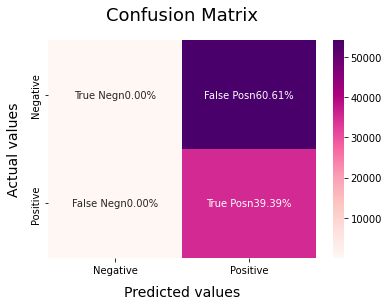

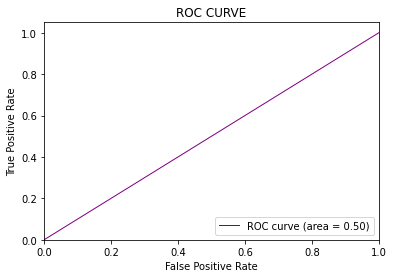

In [ ]:
#Logistic Regression
#model_lr = OneVsRestClassifier(LogisticRegression())

model_lr = LogisticRegression(max_iter = 1000)
model_lr.fit(x_train, y_train)

model_Evaluate(model_lr)
y_pred_lr = model_lr.predict(x_test)


fpr, tpr, thresholds = roc_curve(y_test, y_pred_lr)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='purple', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

              precision    recall  f1-score   support

           0       0.75      0.00      0.00     54170
           1       0.39      1.00      0.57     35201

    accuracy                           0.39     89371
   macro avg       0.57      0.50      0.28     89371
weighted avg       0.61      0.39      0.22     89371



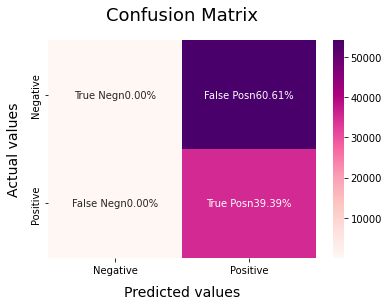

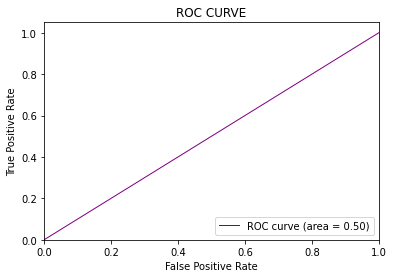

In [ ]:
#Linear Suppor Vector
SVCmodel = LinearSVC()
SVCmodel.fit(x_train, y_train)

model_Evaluate(SVCmodel)
y_pred_svc = SVCmodel.predict(x_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_svc)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='purple', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

              precision    recall  f1-score   support

           0       0.62      0.73      0.67     54170
           1       0.42      0.31      0.36     35201

    accuracy                           0.56     89371
   macro avg       0.52      0.52      0.51     89371
weighted avg       0.54      0.56      0.55     89371



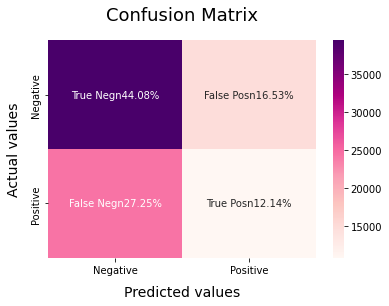

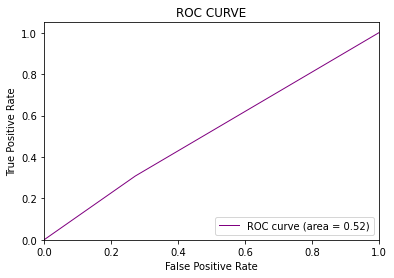

In [ ]:
#Native Bayes
model_nbayes = MultinomialNB()
model_nbayes.fit(x_train, y_train)

model_Evaluate(model_nbayes)
y_pred_nbayes = model_nbayes.predict(x_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_nbayes)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='purple', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()